# Phase 1: Object Detection

## COCO Dataset Loading 

(We download them Manually due to Kernel Crash + Bandwidth Constraints)

In [1]:
#Library imports
import os, requests, zipfile
import json
from PIL import Image
import cv2
from pycocotools.coco import COCO

In [6]:
#Constants

#Official download directory
URLs = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images": "http://images.cocodataset.org/zips/val2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

#Path Configurations
ROOT = "COCO_DATASET"
DOWN_DIR = ROOT
SUBSET_SIZE = 50000
TRAIN_DIR = os.path.join(ROOT, "images", "train2017")
VAL_DIR = os.path.join(ROOT, "images", "val2017")
ANN_TRAIN_DIR = os.path.join(ROOT, "annotations", "instances_train2017.json")
ANN_VAL_DIR = os.path.join(ROOT, "annotations", "instances_val2017.json")

In [ ]:
#Initialize COCO APIs -> it points to the full
cocot = COCO(ANN_TRAIN_DIR)
cocov = COCO(ANN_VAL_DIR)

In [ ]:
#Number of Categories, Image(s), its metadata & Annotations (Counts)
cat_ids = cocot.getCatIds()
cats = cocot.loadCats(cat_ids) #is a list

train_ids = cocot.getImgIds() #get the image ID only (list)
val_ids = cocov.getImgIds()

train_meta = cocot.loadImgs(train_ids)
val_meta = cocov.loadImgs(val_ids)

tann_ids = cocot.getAnnIds()
tann_meta = cocot.loadAnns(tann_ids)

vann_ids = cocov.getAnnIds()
vann_meta = cocov.loadAnns(vann_ids)

print("Number of Train Images: ", len(train_ids))
print("Number of Validation Images: ", len(val_ids))
print("Number of Annotations (Train): ", len(tann_ids))
print("Number of Annotations (Validation): ", len(vann_ids))
print("Number of Categories: ", len(cat_ids))

### Metadata Inspection

| Metadata Type | What it describes    |
| ------------- | -------------------- | 
| `images`      | Whole image          | 
| `annotations` | Objects in the image | 
| `categories`  | Class mapping        | 

`image` metadata:
- id $\to$ unique identifier to link with annotations
- file_name $\to$ local filename of the image
- height & width $\to$ image resolution
- date_captured $\to$ self-explanatory
- license, coco_url, flickr_url $\to$ copyright formality

`annotation` metadata:
- image_id $\to$ links annotation to image
- category_id $\to$ associates image to category (for object recognition training)
- bbox [x_min, y_min, width, height] in pixel units (for object detection)
- segmentation $\to$ polygon masks describing pixel level shape (semantic/instance segmentation)
- area $\to$ number of pixels inside the segmentation
- iscrowd $\to$ 1 if group objects merged into one (special loss handling in crowded scenes)
- id $\to$ unique identifier for annotation

`categories` metadata:
- name $\to$ the class label (used for training + readable output)
- id $\to$ numeric label assigned to that class (the model trains on numerical indexes)
- supercategory $\to$ high-level grouping of name (useful for hierarchical classification/filtering)

In [ ]:
#Inspect the metadatas
print("Ex. of Category Metadata: ", cats[0])
print("Ex. of Image (Train) Metadata: ", timg_meta[0])
print("Ex. of Annotation (Train) Metadata: ", tann_meta[0])

#List out the keys
meta_cat_keys = cats[0].keys()
meta_img_keys = timg_meta[0].keys()
meta_ann_keys = tann_meta[0].keys()

print(meta_cat_keys)
print(meta_img_keys)
print(meta_ann_keys)

### Subset Creation (11 Classes Focus)

In [ ]:
TARGET_CLASSES = [
    "microwave", "oven", "refrigerator", "sink", "toaster",
    "cell phone", "keyboard", "laptop", "mouse", "remote", "tv"
]

In [ ]:
target_cat_ids = cocot.getCatIds(catNms=TARGET_CLASSES)
target_cats = cocot.loadCats(target_cat_ids)
print("Target Categories: ", target_cats)

ann_train_ids =cocot.getAnnIds(catIds=target_cat_ids)
ann_val_ids =cocov.getAnnIds(catIds=target_cat_ids)
print('Total Target Annotations (Before Limiting): ', len(ann_train_ids) + len(ann_val_ids))

sub_train_ann = cocot.loadAnns(ann_train_ids)
sub_val_ann = cocov.loadAnns(ann_val_ids)
print("Filtered Train Annotations:", len(sub_train_ann))
print("Filtered Val Annotations:", len(sub_val_ann))


sub_train_img_ids = list({ann['image_id'] for ann in sub_train_ann})
sub_val_img_ids = list({ann['image_id'] for ann in sub_val_ann})

sub_train_img = cocot.loadImgs(sub_train_img_ids)
sub_val_img = cocov.loadImgs(sub_val_img_ids)

print("Total Target Images (Before Limiting): ", len(sub_train_img) + len(sub_val_img))


filtered_cocot = {
    "info": cocot.dataset.get("info", {}),
    "licenses": cocot.dataset.get("licenses", []),
    "images": sub_train_img,
    "annotations": sub_train_ann,
    "categories": target_cats,       
}

filtered_cocov = {
    "info": cocov.dataset.get("info", {}),
    "licenses": cocov.dataset.get("licenses", []),
    "images": sub_val_img,
    "annotations": sub_val_ann,
    "categories": target_cats,       
}

with open('COCO_DATASET/annotations/coco_train_subset.json', "w") as f:
    json.dump(filtered_cocot, f)

with open('COCO_DATASET/annotations/coco_val_subset.json', "w") as f:
    json.dump(filtered_cocov, f)

### Class Balance Distribution

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Path pt.2
SUBSET_TRAIN = "COCO_DATASET/annotations/coco_train_subset.json"
SUBSET_VAL = "COCO_DATASET/annotations/coco_val_subset.json"

#Initialize COCO APIs for subset
cot = COCO(SUBSET_TRAIN)
cov = COCO(SUBSET_VAL)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:

# Get all annotation IDs and metadata
tann_ids = cot.getAnnIds()
tanns = cot.loadAnns(tann_ids)
vann_ids = cov.getAnnIds()
vanns = cov.loadAnns(vann_ids)

# Count category frequencies
catt_counts = Counter([ann["category_id"] for ann in tanns])
catv_counts = Counter([ann["category_id"] for ann in vanns])

# Load category info (Name mapping)
categories = cot.loadCats(cot.getCatIds())
cat_id_to_name = {cat["id"]: cat["name"] for cat in categories}

# Sort by frequency
sorted_train_freq = sorted(catt_counts.items(), key=lambda x: x[1], reverse=True)
sorted_val_freq = sorted(catv_counts.items(), key=lambda x: x[1], reverse=True)

labels_train = [cat_id_to_name[cat_id] for cat_id, _ in sorted_train_freq]
labels_val = [cat_id_to_name[cat_id] for cat_id, _ in sorted_val_freq]

counts_train = [count for _, count in sorted_train_freq]
counts_val = [count for _, count in sorted_val_freq]

In [ ]:
# Display results for train dataset
for cat_id, freq in sorted_train_freq:
    print(f"{cat_id_to_name[cat_id]:<15} : {freq}")

In [ ]:
# Display results for validation dataset
for cat_id, freq in sorted_val_freq:
    print(f"{cat_id_to_name[cat_id]:<15} : {freq}")

In [ ]:
#Distribution Visualizaiton (Combined)
plt.figure(figsize=(20,8))
plt.bar(labels_train + labels_val, counts_train + counts_val)
plt.xticks(rotation=45)
plt.title("Class Distribution (Combined)")
plt.show()

#Check Imbalance Ratio
print("Imbalance ratio (max/min): ", max(counts_train) / min(counts_train))

In [ ]:
#Basic Statistics Informations
freq_data = sorted_train_freq
#Separate into labels and counts
classes = [str(c[0]) for c in freq_data]
counts = np.array([c[1] for c in freq_data])

#Compute stats
mean_count = np.mean(counts)
std_dev = np.std(counts)
percentages = (counts / np.sum(counts)) * 100

print("Total Objects:", np.sum(counts))
print("Number of Classes:", len(classes))
print("Mean Images per Class:", round(mean_count, 2))
print("Standard Deviation:", round(std_dev, 2))


In [ ]:
print("\nPercentage contribution per class:")
for class_name, pct in zip(classes, percentages):
    print(f"- {class_name}: {pct:.2f}%")

### Imbalance Handling (Optimalization -> LATER)

## Pairing Image to Annotation (API Approach)

In [1]:
import os, requests, zipfile
import json
from PIL import Image
import cv2
from pycocotools.coco import COCO

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
def get_pairs(img_dir, ann_path):
    coco = COCO(ann_path)

    #Initialize a list for pairs
    pairs = []

    for img_id in coco.imgs.keys():
        #Get metadata for each image
        img_info = coco.imgs[img_id]
        img_file = os.path.join(img_dir, img_info['file_name'])

        #Get annotaiton IDs linked to this image
        ann_ids = coco.getAnnIds(imgIds = img_id)
        anns = coco.loadAnns(ann_ids)

        #Group them into a training pair entry
        pairs.append({
            "image_path": img_file,
            "annotations": anns, #Should contain a list of bbox and category_id dicts
            "width": img_info["width"],
            "height": img_info["height"],
            "image_id": img_id
        })
    
    return pairs

In [2]:
#Save & Reload le COCO Pairs 
import json

def save_pairs(pairs, save_path):
    with open(save_path, "w") as f:
        json.dump(pairs, f, indent = 4)
    print("Saved pairs to ", save_path)

def load_pairs(save_path):
    with open(save_path, "r") as f:
        return json.load(f)

In [12]:
train_pairs = get_pairs(TRAIN_DIR, SUBSET_TRAIN)
val_pairs = get_pairs(VAL_DIR, SUBSET_VAL)

print(train_pairs[0])
print(val_pairs[0])
print("Total TRAIN pairs:", len(train_pairs))
print("Total VAL pairs:", len(val_pairs))

save_pairs(train_pairs, "coco_train_pairs.json")
save_pairs(val_pairs, "coco_val_pairs.json")

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{'image_path': 'COCO_DATASET\\images\\train2017\\000000131074.jpg', 'annotations': [{'segmentation': [[283.47, 194.46, 271.43, 192.79, 274.44, 189.61, 285.65, 191.61]], 'area': 39.811199999999815, 'iscrowd': 0, 'image_id': 131074, 'bbox': [271.43, 189.61, 14.22, 4.85], 'category_id': 75, 'id': 1630619}], 'width': 640, 'height': 428, 'image_id': 131074}
{'image_path': 'COCO_DATASET\\images\\val2017\\000000555009.jpg', 'annotations': [{'segmentation': [[267.38, 150.72, 269.79, 3.72, 271.0, 1.31, 490.29, 1.92, 476.43, 115.78, 474.62, 118.79, 472.82, 127.23, 474.02, 130.84, 473.42, 135.66, 462.58, 151.32, 457.76, 165.78, 457.76, 170.6, 424.02, 167.59, 423.42, 160.96, 418.6, 155.54, 396.31, 151.32, 387.27, 153.13, 385.46, 165.18, 267.38, 155.54, 266.78, 151.93]], 'area': 33538.308099999995, 'iscrowd': 0, 'image_id': 555009, 'bb

In [3]:
train_pairs = load_pairs("coco_train_pairs.json")
val_pairs = load_pairs("coco_val_pairs.json")

In [19]:
for ann in train_pairs[0]["annotations"]:
    print("Original bbox:", ann["bbox"])

Original bbox: [271.43, 189.61, 14.22, 4.85]


### Region Proposal

Selective Search (SS) matter because instead of checking every single possible pixel combination (approximately billions), SS suggests only a few thousand regions (around 2k to 4k), making the classification task computationally feasible.

In [10]:
#Make sure cv2.ximgproc.segmentation is available via the existing opencv-contrib-python installation)

#Initialize Selective Search Segmentation
eb = cv2.ximgproc.createEdgeBoxes()
eb.setMaxBoxes(50) #Max num of proposals to return
eb.setAlpha(0.65) #Step size
eb.setBeta(0.75) #Ridge sensitivity
eb.setMinScore(0.01) #Filter Weak Boxes

In [7]:
def propose_regions(img):
    """
    Input (img) : cv2.imread() (BGR)
    Output: [x_min, y_min, x_max, y_max]
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = edges.astype(np.float32)/255.0
    orientation = np.zeros_like(edges, dtype=np.float32)

    boxes, scores = eb.getBoundingBoxes(edges, orientation)

    converted = []
    #Convert [x, y, w, h] to [x_min, y_min, x_max, y_max]
    for (x, y, w, h) in boxes:
        converted.append([x, y, x + w, y + h])

    #Return as float32 array
    return np.array(converted, dtype=np.float32)


In [8]:
#Iou Calculation -> Validating the Proposed Regions to Ground Truth

#Convert GT boxes to minmax format
def coco_to_minmax(bbox):
    x, y, w, h = bbox
    return [x, y, x + w, y + h]

#IoU calculation
def calculate_iou(boxA, boxB):
    """
    Both boxA and boxB are in [x_min, y_min, x_max, y_max] format
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])

    unionArea = float(boxAArea + boxBArea - interArea)

    if unionArea == 0:
        return 0.0
    
    iou = interArea/unionArea

    return iou

In [ ]:
#Label the Regions based on IoU

def get_labeled_regions(coco_pairs, output_json, pos_iou_thresh=0.5, neg_iou_thresh=0.1):
    dataset = []

    print("Processing ", len(coco_pairs), " images for region labeling...")
    for sample in tqdm(coco_pairs, desc="labeling regions"):
        img_path = sample["image_path"]
        ann = sample["annotations"]
        
        gt_boxes = [coco_to_minmax(b["bbox"]) for b in ann]
        gt_labels = [b["category_id"] for b in ann]

        img = cv2.imread(img_path)
        if img is None:
            continue

        proposed_regions = propose_regions(img)

        labeled_regions = []
        for pr in proposed_regions:
            max_iou = 0
            best_idx = -1

            for i, gt in enumerate(gt_boxes):
                iou = calculate_iou(pr, gt)
                if iou > max_iou:
                    max_iou = iou
                    best_idx = i

            label = -1
            if max_iou >= pos_iou_thresh:
                label = gt_labels[best_idx]  # positive (object class)
            elif max_iou <= neg_iou_thresh:
                label = 0  # negative (background)
            
            if label != -1:
                labeled_regions.append({
                    "box": pr.tolist(),
                    "label": label,
                    "iou": round(float(max_iou), 4)
                })
        
        if len(labeled_regions) > 0:
            dataset.append({
                "image_path": img_path,
                "regions": labeled_regions
            })

    with open(output_json, "w") as f:
        json.dump(dataset, f, indent=4)

    print(f"Saved {len(dataset)} images worth of region proposals to {output_json}")
    return dataset

In [ ]:
training_region = get_labeled_regions(
    coco_pairs=train_pairs[:1000],
    output_json="train_region_dataset.json"
)

val_region = get_labeled_regions(
    coco_pairs=val_pairs[:200],
    output_json="val_region_dataset.json"
)

KeyboardInterrupt: 

#### DEBUG PROPOSED REGIONS

In [ ]:
def draw_box(img, box, color, thickness=2):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

def show_iou_debug(img_path, gt_bbox, max_regions=50):
    """
    gt_bbox should be in COCO format: [x, y, w, h]
    """

    img = cv2.imread(img_path)
    if img is None:
        print("Error: cannot load image:", img_path)
        return
    
    # Convert COCO bbox → xyxy
    gx, gy, gw, gh = gt_bbox
    gt_xyxy = [gx, gy, gx + gw, gy + gh]

    proposals = propose_regions(img)[:max_regions]

    vis = img.copy()
    
    # Draw ground truth in RED
    draw_box(vis, gt_xyxy, (255, 0, 0), 3)

    max_iou = 0
    best_box = None

    # Compute IoU and draw proposals in GREEN
    for pr in proposals:
        iou = calculate_iou(pr, gt_xyxy)
        # draw_box(vis, pr, (0, 255, 0), 1)
        
        if iou > max_iou:
            max_iou = iou
            best_box = pr

    # Highlight best IoU in BLUE
    if best_box is not None:
        draw_box(vis, best_box, (0, 0, 255), 3)

    print("Max IoU among proposals:", max_iou)

    # Show image
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(vis)
    plt.axis("off")


# Example usage:
sample = train_pairs[2]
img_path = sample["image_path"]
gt_bbox = sample["annotations"][0]["bbox"]

show_iou_debug(img_path, gt_bbox)

In [30]:
def draw_gt_only(img_path, annotations, thickness=2):
    """
    annotations: list of COCO-style bboxes [x, y, w, h]
    """

    img = cv2.imread(img_path)
    if img is None:
        print("Cannot load image:", img_path)
        return

    vis = img.copy()

    for ann in annotations:
        bx, by, bw, bh = ann["bbox"]

        x1 = int(bx)
        y1 = int(by)
        x2 = int(bx + bw)
        y2 = int(by + bh)

        # RED for ground truth
        cv2.rectangle(vis, (x1, y1), (x2, y2), (255, 0, 0), thickness)

    # Show image (convert to RGB)
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(vis)
    plt.title("Ground Truth Only")
    plt.axis("off")

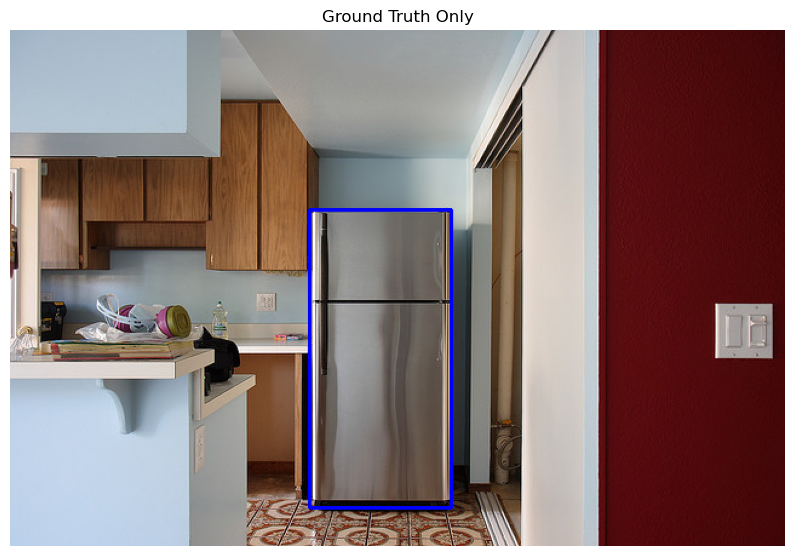

In [31]:
sample = train_pairs[6]
img_path = sample["image_path"]
annotations = sample["annotations"]

draw_gt_only(img_path, annotations)

In [34]:
def draw_proposals_only(img_path, max_regions=10, thickness=1):
    """
    Visualize only the proposed regions from propose_regions(img).
    """

    img = cv2.imread(img_path)
    if img is None:
        print("Cannot load image:", img_path)
        return

    vis = img.copy()

    # Generate region proposals
    proposals = propose_regions(img)[:max_regions]  # limit for clarity

    # Draw proposals in GREEN
    for pr in proposals:
        x1, y1, x2, y2 = map(int, pr)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), thickness)

    # Show image
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(vis)
    plt.title(f"Proposed Regions Only (showing {len(proposals)})")
    plt.axis("off")


### Feature Extraction/Encoding

Produce a final profuct of Feature Matrix (X_train) where each row is a BoVW histogram (400 dimensions)
- Because the SVM needs numerical features to learn th epatterns of each object class
- We include CLAHE, SIFT, Scaler, and BoVW encoder.
    - Crop region -> CLAHE enhancement
    - Extract SIFT keypoints + descriptors
    - Save descriptors for clustering later (BoVW vocabulary)

Another thing to produce is the Label vector (Y_train), where each entry is the corresponding class ID (0 for background, 72-82 for objects)
- Because the SVM needs the ground truth "answer" for every feature vector to adjust its weights.
- We use the selective search + IoU + labelling logic

#### SIFT

In [21]:
from tqdm import tqdm

#Initialized CLAHE and SIFT
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
sift = cv2.SIFT_create()

In [22]:
def preprocess_regions(img):
    #Convert to grayscale & apply CLAHE
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = clahe.apply(gray)

    return eq

In [23]:
def extract_region_sift(img, regions, max_regions=30):
    region_desc_list = []
    valid_boxes = []

    for (x1, y1, x2, y2) in regions[:max_regions]:
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        if x2 <= x1 or y2 <= y1:
            continue

        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        gray_crop = preprocess_regions(crop)
        keypoints, descriptors = sift.detectAndCompute(gray_crop, None)

        if descriptors is not None:
            region_desc_list.append(descriptors)
            valid_boxes.append([x1, y1, x2, y2])
            
    if len(region_desc_list) == 0:
        return np.zeros((1,128), dtype=np.float32), np.zeros((0,4), dtype=np.int32)

    region_desc = np.vstack(region_desc_list)  # Big pool of descriptors
    return region_desc, np.array(valid_boxes)

In [24]:
def extract_manual_feat(img_path, max_regions=30):
    img = cv2.imread(img_path)
    if img is None:
        print(f"IMG {img_path} NOT FOUND WOI")
        return np.zeros((1, 128)), np.zeros((0, 4))
    
    img = cv2.resize(img, (256, 256))
    regions = propose_regions(img)

    region_desc, boxes = extract_region_sift(img, regions)

    return region_desc, boxes

#### BoVW

In [ ]:
#Extract region SIFT features from training set

region_dict = {d['image_path']: d['regions'] for d in training_region}
all_desc = []

#Limit the image for trial 
for sample in tqdm(train_pairs[:1000]):
    img_path = sample["image_path"]
    
    img = cv2.imread(img_path)
    if img is None:
        continue

    labeled_regions = region_dict.get(img_path, [])

    for region in labeled_regions:
        x1, y1, x2, y2 = map(int, region['box'])
        crop = img[y1:y2, x1:x2]

        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        _, desc = sift.detectAndCompute(gray, None)
        
        if desc is not None:
            all_desc.append(desc)

all_desc = np.vstack(all_desc)
print("Total descriptors extracted:", all_desc.shape)

  0%|          | 0/100 [00:01<?, ?it/s]


NameError: name 'training_region' is not defined

In [ ]:
#Build Visual Vocabulary with K-Means
#Note: len(all_desc) > VOCAB_SIZE
#all_desc must be shaped (N, 128) 
from sklearn.cluster import MiniBatchKMeans

VOCAB_SIZE = 200 #Tune later to 100-1000

km = MiniBatchKMeans(n_clusters=VOCAB_SIZE, random_state=42, batch_size=2000)
km.fit(all_desc)

np.save("kmeans_vocab.npy", km.cluster_centers_)
print("Saved visual vocabulary to kmeans_vocab.npy")

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
#Convert Each Region -> BoVW Histogram Encoding
def encode_bovw(desc, kmeans, vocab_size=VOCAB_SIZE):
    if desc is None or len(desc) == 0:
        hist = np.zeros(vocab_size)
    else:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1))
    return hist/(np.linalg.norm(hist) + 1e-6)

In [ ]:
#Build the Training Set for Classifier
X_train = []
y_train = []

for img_path, anns in tqdm(train_pairs[:100]):
    img = cv2.imread(img_path)
    proposals = propose_regions(img)

    gt_boxes = [a['bbox'] for a in anns]
    gt_labels = [a['category_id'] for a in anns]

    labeled_regions = get_labeled_regions(proposals, gt_boxes, gt_labels)

    for region in labeled_regions:
        x1,y1,x2,y2 = map(int, region['box'])
        crop = img[y1:y2, x1:x2]
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

        _, desc = sift.detectAndCompute(gray, None)
        hist = encode_bovw(desc, km, VOCAB_SIZE)

        X_train.append(hist)
        y_train.append(region['label'])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Training samples:", X_train.shape)
print("Label samples   :", y_train.shape)


### Model Construction, Training, and Evaluation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
#Define the Fully Connected Layer (Neural Feature Mapper)
class FeatureMapper(nn.Module):
    #BoVW size must match (input_dim to VOCAB_SIZE)
    def __init__(self, input_dim=200, embed_dm=64):
        super(FeatureMapper, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

        def forward(self, x):
            return self.fc(x)

In [ ]:
#Training the Feature Mapper to minimize class separation loss so SVM receives better embedding

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)


train_loader = DataLoader(
    TensorDataset(X_tensor, y_tensor),
    batch_size=256, shuffle=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FeatureMapper().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "feature_mapper.pth")
print("Saved trained mapper!")

In [ ]:
#Extract learned embeddings

model.eval()

with torch.no_grad():
    X_embed = model(X_tensor.to(device)).cpu().numpy()

print("Original BoVW:", X_train.shape)
print("Mapped Embedding:", X_embed.shape)

In [ ]:
#Train SVM on the Learned Embeddings
from sklearn.svm import LinearSVC
import joblib

In [ ]:
svm = LinearSVC(C=1.0, class_weight="balanced", max_iter=1000)
svm.fit(X_embed, y_train)

joblib.dump(svm, "svm_classifier.pkl")
print("Saved SVM classifier to svm_classifier.pkl")

#### Evaluation and Testing

# Phase 2: JSON Construction

# Phase 3: LLM Captioning